In [345]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from string import letters
%matplotlib inline

sns.set(style="white")

# Read a dataset
d=pd.read_csv('training_set.csv',header=None,index_col=False)

#d.iloc[:,range(40)+[58]]
d.columns = ['id']+range(60)
d.index = d['id']
d=d.drop('id',1)
d_full=d

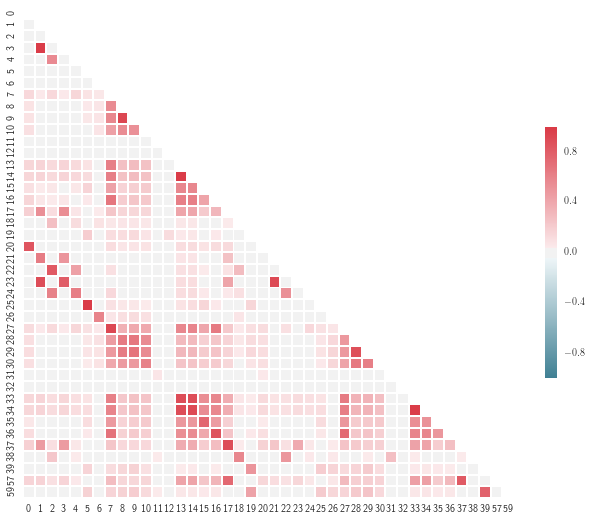

In [303]:
# Compute the correlation matrix
corr = d.ix[:,range(40)+[57,59]].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, #vmax=.5,
            square=True, #xticklabels=2, yticklabels=2,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

f.savefig('corr.pdf')

In [308]:
corr.ix[57,corr.ix[57,:]>0.2]


7     0.284958
13    0.427584
14    0.423876
15    0.241172
16    0.332576
17    0.744888
27    0.298160
33    0.450552
34    0.449394
35    0.210824
36    0.312084
37    0.821725
57    1.000000
Name: 57, dtype: float64

In [444]:
## Train something

#dataset is randomized already, so take first half for training, second half for testing
#first remove anomalous number of commits

jun_tot=d.ix[:,0:20].sum(1)
jul_tot=d.ix[:,20:40].sum(1)
aug_tot=d.ix[:,40:60].sum(1)

quality_repo=jun_tot&jul_tot

event_req=((d_full.ix[:,range(40)]>0).sum(1)>7) & (d_full.ix[:,[13,14,15,33,34,35]].sum(1)>=2)

d=d_full.ix[(event_req) & (jun_tot>=100) & (jul_tot>=100),:]
#d=d_full

num_entries=d.shape[0]
print num_entries
row_index=list(d.index)
training_rows = row_index[:num_entries/2]
testing_rows = row_index[num_entries/2:]

#first 40 columns are the predictors of the model
predictor_col=range(40) # [1,3,17,21,23,37] 
#target is the number of pushes in August
target_col=[59]

#Make training and testing sets
X_train=d.ix[training_rows,predictor_col]
#y_train=d.ix[training_rows,40:60].sum(1)
y_train=d.ix[training_rows,target_col]
y_train=np.array(y_train.transpose())[0]
y_train_class=np.array(d.ix[training_rows,39]*2+10<d.ix[training_rows,59])

X_test=d.ix[testing_rows,predictor_col]
#y_test=d.ix[testing_rows,40:60].sum(1)
y_test=d.ix[testing_rows,target_col]
y_test=np.array(y_test.transpose())[0]
y_test_class=np.array(d.ix[testing_rows,39]*2+10<d.ix[testing_rows,59])


6792


In [445]:
# Fit regression model
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.1, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=4, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=1,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [328]:
# Fit Linear model

lin_reg = LinearRegression()
lin_reg.fit(X_train.ix[:,[13,14,17,33,34,37]], y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [342]:
# Fit GLM Model
import statsmodels.api as sm

poisson_model = sm.GLM(y_train, X_train.ix[:,[17,37]], family=sm.families.Gamma())
poisson_result = poisson_model.fit()


In [297]:
# Fit RandomForest
rf=RandomForestRegressor(n_estimators=1000, min_samples_split=2, n_jobs=2, max_depth=6)
rf.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=2, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [438]:
# Fit Regression for watchers
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.1, 'loss':'ls'}

gbr = GradientBoostingRegressor(**params)

gbr.fit(X_train, y_train)


GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=4, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=1,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [443]:
from sklearn.metrics import precision_recall_fscore_support

y_pred_class=gbc.predict(X_test)
precision_recall_fscore_support(y_test_class,y_pred_class)
print sum(y_test_class==0)
print sum((y_pred_class==y_test_class) & (y_test_class==1))


3339
0


In [447]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, clf.predict(X_test))
#mse = mean_squared_error(y_test, X_test.ix[:,[37]])
print("MSE: %.4f" % mse)

MSE: 12495.9910


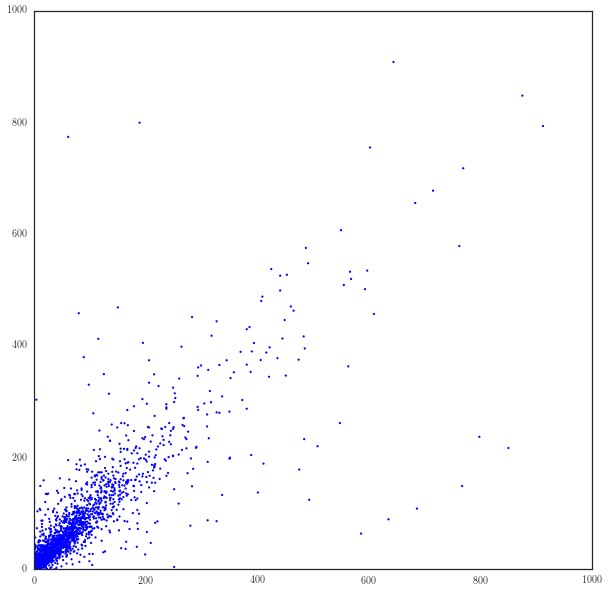

In [451]:
del fig, ax1
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

## the data
N = len(y_test)
x = y_test
#y = y_test-poisson_results.predict(X_test)
y = clf.predict(X_test)
#y=rf.predict(X_train)
#y = lin_reg.predict(X_test.ix[:,[13,14,17,33,34,37]])
#y=poisson_result.predict(X_test.ix[testing_rows,[17,37]])


#jun=np.array(X_test.ix[:,[17]].transpose())[0]
#jul=np.array(X_test.ix[:,[37]].transpose())[0]
#aug=y_test
jun=d.ix[testing_rows,0:20].sum(1)
jul=d.ix[testing_rows,20:40].sum(1)
aug=d.ix[testing_rows,40:60].sum(1)

## left panel
ax1.scatter(x,y,color='blue',s=5,edgecolor='none')
#ax1.scatter(jun,aug,color='blue',s=5,edgecolor='none')
#ax1.scatter(jul,aug,color='green',s=5,edgecolor='none')
#ax1.set_aspect(1./ax1.get_data_ratio()) # make axes square
ax1.set_ylim([0,1000])
ax1.set_xlim([0,1000])


plt.show()


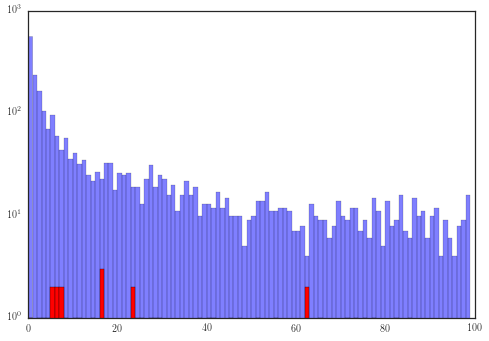

In [570]:
#Try to find anamolies
anom=d.ix[training_rows,39]*2+10<d.ix[training_rows,59]
not_anom=d.ix[training_rows,39]*2+10>d.ix[training_rows,59]


fig = plt.figure()
ax = fig.add_subplot(111)

col=39
numBins = 50
plt.gca().set_yscale("log")
ax.hist(np.array(X_train.ix[not_anom,col]),bins=range(0,100),color='blue',alpha=0.5)
ax.hist(np.array(X_train.ix[anom,col]),bins=range(0,100),color='red',alpha=1.0)
#ax.set_xlim([0,2000])
plt.show()


In [586]:
#Calculate classifier
anom=d.ix[training_rows,39]*2+10<d.ix[training_rows,59]
not_anom=d.ix[training_rows,39]*2+10>d.ix[training_rows,59]

anom_pred=(d.ix[training_rows,0]<5)&(d.ix[training_rows,1]<10)&(d.ix[training_rows,2]<5)&(d.ix[training_rows,3]<10)&(d.ix[training_rows,4]<1)&(d.ix[training_rows,5]<15)&(d.ix[training_rows,6]<5)&(d.ix[training_rows,8]<20)&(d.ix[training_rows,9]<20)&(d.ix[training_rows,10]<5)&(d.ix[training_rows,11]<3)&(d.ix[training_rows,12]<2)&(d.ix[training_rows,13]<20)&(d.ix[training_rows,14]<20)&(d.ix[training_rows,15]<3)&(d.ix[training_rows,16]<10)&(d.ix[training_rows,17]<50)&(d.ix[training_rows,18]<5)&(d.ix[training_rows,20]<5)&(d.ix[training_rows,21]<20)&(d.ix[training_rows,22]<5)&(d.ix[training_rows,23]<10)&(d.ix[training_rows,24]<2)&(d.ix[training_rows,25]<20)&(d.ix[training_rows,26]<10)&(d.ix[training_rows,28]<30)&(d.ix[training_rows,30]<5)&(d.ix[training_rows,31]<3)&(d.ix[training_rows,32]<3)&(d.ix[training_rows,33]<30)&(d.ix[training_rows,34]<30)&(d.ix[training_rows,35]<4)&(d.ix[training_rows,36]<20)&(d.ix[training_rows,37]<50)&(d.ix[training_rows,38]<5)

print sum(anom_pred)
print sum(anom)
print sum((anom_pred==anom) &(anom==1))


290
49
11


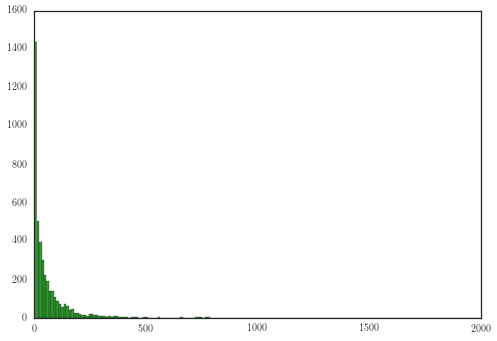

21756


TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [201]:
fig = plt.figure()
ax = fig.add_subplot(111)

numBins = 2000
ax.hist(list(d.ix[testing_rows,57]),numBins,color='green',alpha=0.8)
ax.set_xlim([0,2000])
plt.show()
print max(list(d.ix[training_rows,57]))
print d[d.ix[training_rows,57] >20000,:].index

(array([  489.,   760.,  3816.,  1856.,  2356.,  2174.,  2816.,  2325.,
         2305.,  2174.,  2464.,  2307.,  2288.,  2491.,  2461.,  2370.,
         2376.,  2229.,  2022.,  1760.,  1513.,  1225.,  1119.,   853.,
          665.,   912.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.]),
 <a list of 26 Patch objects>)

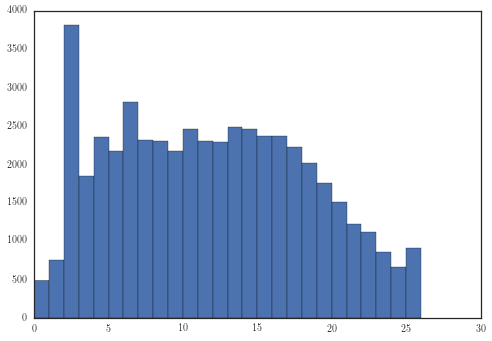

In [252]:
#d_full.ix[list((d_full.ix[:,57] >1000)&(d_full.ix[:,41] >0)&(d_full.ix[:,53] >0)),40:60].transpose()
#plt.hist(list((d_full.ix[:,[0,1,2,3,4,7,8,9,13,14,16,17,19,20,21,22,23,24,27,28,29,33,34,36,37,39]]>0).sum(1)),26,[0,26])
plt.hist(list((d_full.ix[:,range(40)]>0).sum(1)),26,[0,26])


In [312]:
import statsmodels.api as sm
data = sm.datasets.scotland.load()
data.exog = sm.add_constant(data.exog)

# Instantiate a gamma family model with the default link function.
gamma_model = sm.GLM(data.endog, data.exog, family=sm.families.Gamma())
gamma_results = gamma_model.fit()

In [281]:
X_train.ix[y_train>2000,:].transpose()

id,13509108,15100395,19853934
0,2,0,71
1,9,0,378
2,3,0,0
3,0,0,173
4,0,0,0
5,24,25,2
6,0,0,0
7,2,11,0
8,0,6,0
9,0,1,0


49
3396


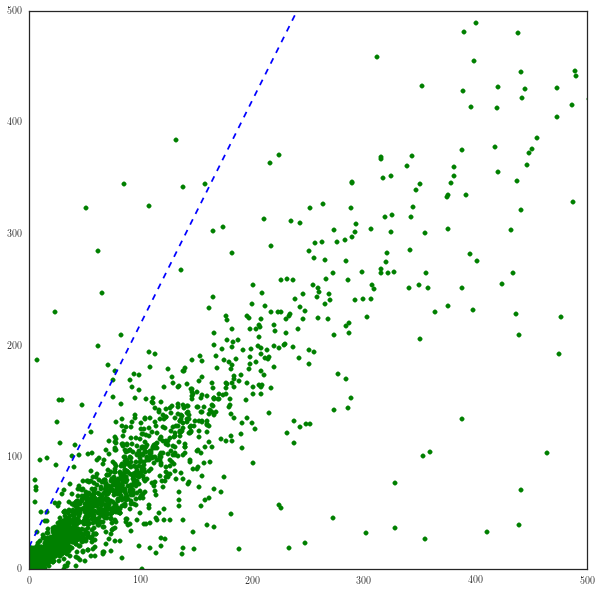

In [430]:
import math
print sum(np.array(d.ix[training_rows,39]*2+10<d.ix[training_rows,59]))
print len(training_rows)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(d.ix[training_rows,39],d.ix[training_rows,59],color='green')
ax.set_xlim([0,500])
ax.set_ylim([0,500])
ax.plot([0,1000],[20,2020], "r--",label='test',color='blue')
plt.show()

